In [ ]:
!pip install zarr

In [2]:
from typing import List

import matplotlib.pyplot as plt
from dask.array import Array as DaskArray
from matplotlib import colors
from shapely.affinity import translate
from shapely.geometry import box

from training import *
from vesuvius.data_io import *
from vesuvius.dataloader import *
from vesuvius.sampler import *
from vesuvius.utils import *

try:
    from typing import Protocol
except ImportError:
    from typing_extensions import Protocol

dask.config.set(scheduler='synchronous')

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

2023-04-17 04:52:45.982862: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-17 04:52:46.566457: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Using the cpu

Getting config from Configuration instantiation...



/home/john/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:107: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


device(type='cpu')


## Plot fragment 1, with the test box and the mask

The labels are coarsened to BOX_WIDTH_SAMPLE

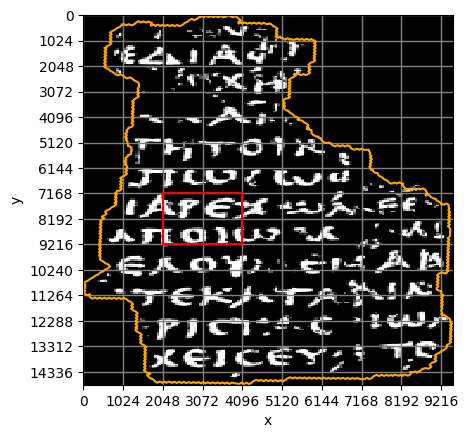

In [3]:
def plot_mask(dataset, big_mask_poly, test_box_poly, large=1024, sample=config1.box_width_xy) -> None:
    fig, ax1 = plt.subplots(1, 1)
    labels = dataset['labels'].astype(int)
    labels_coarse = dataset['labels'].astype(np.float32).coarsen(x=sample, y=sample,
                                                                 boundary='pad').mean()
    height, width = labels.shape
    aspect_ratio = width / height
    labels_coarse.plot.imshow(col_wrap=5, robust=True, yincrease=False, cmap='gray', add_colorbar=False, ax=ax1)
    xticks = np.arange(0, labels.shape[1], large)
    yticks = np.arange(0, labels.shape[0], large)
    ax1.set_xticks(xticks)
    ax1.set_yticks(yticks)
    ax1.grid(True, which='both', color='gray', linestyle='-', linewidth=1)
    ax1.plot(*big_mask_poly.exterior.xy, 'orange')
    ax1.plot(*test_box_poly.exterior.xy, 'red')
    ax1.set_aspect(aspect_ratio)


def get_ploy_mask(ds_demo: xr.Dataset) -> Polygon:
    poly_mask_demo = vectorise_raster(ds_demo['mask'].pad(x=1, y=1, mode="constant", constant_values=False).values)
    return translate(poly_mask_demo, xoff=int(ds_demo.x[0]), yoff=int(ds_demo.y[0]))


def get_data_and_plot_masks(fragment=config1.test_box_fragment, hold_back_rect=config1.test_box) -> None:
    ds_demo = read_dataset_from_zarr(fragment, config1.num_workers, config1.prefix, normalize=True)
    poly_mask_demo = get_ploy_mask(ds_demo)
    plot_mask(ds_demo, poly_mask_demo, coords_to_poly(hold_back_rect))


get_data_and_plot_masks()

|## Get slices from the dataset

In [6]:
config1.test_box

(2048, 7168, 4093, 9216)

Ratio of ink to no-ink pixels: 0.4999


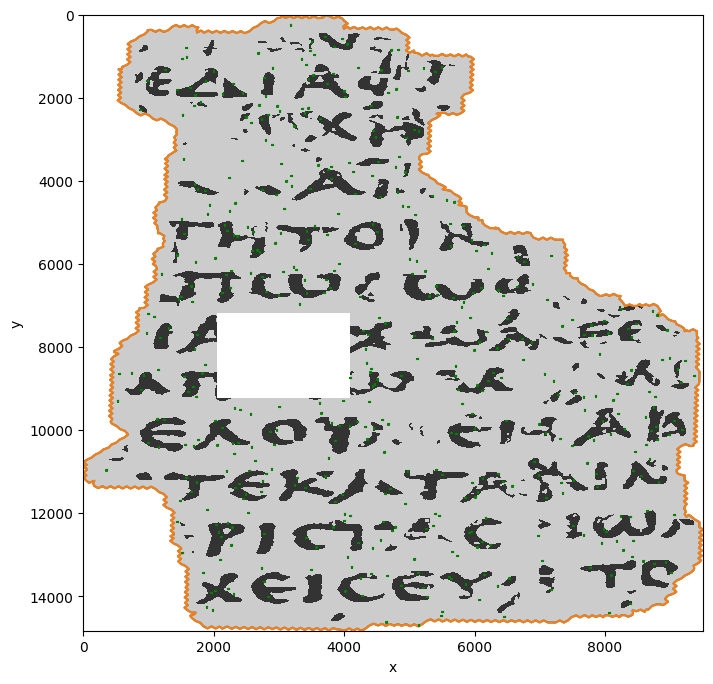

In [4]:
def plot_random_slice(slices: List,
                      labels_arr: DaskArray,
                      mask_arr: DaskArray,
                      mask_poly: Polygon,
                      test_box_poly: Polygon) -> None:
    fig, ax1 = plt.subplots(1, 1, figsize=(8, 8))
    ax1.plot(*mask_poly.exterior.xy)
    ax1.plot(*test_box_poly.exterior.xy)
    for slice_ in slices:
        rnd_box = box(slice_['x'].start,
                      slice_['y'].start,
                      slice_['x'].stop,
                      slice_['y'].stop)
        ax1.plot(*rnd_box.exterior.xy, color='green')
    ax1.invert_yaxis()
    ax1.set_title('Papyrus mask 1, test box & sample boxes')
    cmap = colors.ListedColormap(['0.8', '0.2'])
    labels_arr.astype('int').where(mask_arr).plot.imshow(ax=ax1, cmap=cmap, add_colorbar=False)
    ax1.invert_yaxis()


def plot_random_slices(samples: int, box_=config1.test_box) -> None:
    ds_demo = read_dataset_from_zarr(config1.test_box_fragment, config1.num_workers, config1.prefix)
    ds_demo['full_mask'] = get_hold_back_mask(ds_demo, box_)
    rvs = VolumeSamplerRndXYZ(ds_demo, config1.box_width_z, config1.box_width_xy, samples, balance=True)
    poly_mask_demo = vectorise_raster(ds_demo['mask'].pad(x=1, y=1, mode="constant", constant_values=False).values)
    slices = [s for s in rvs]
    plot_random_slice(slices, ds_demo.labels, ds_demo.full_mask.load(), poly_mask_demo, poly_mask_demo)
    print(f"Ratio of ink to no-ink pixels: {rvs.total_ink_pixels / rvs.total_pixels:.4f}")


plot_random_slices(1000)

Loading test data took 1.91 seconds
Loss: 0.584492902085185 (step 80) at 7.240570545196533 seconds


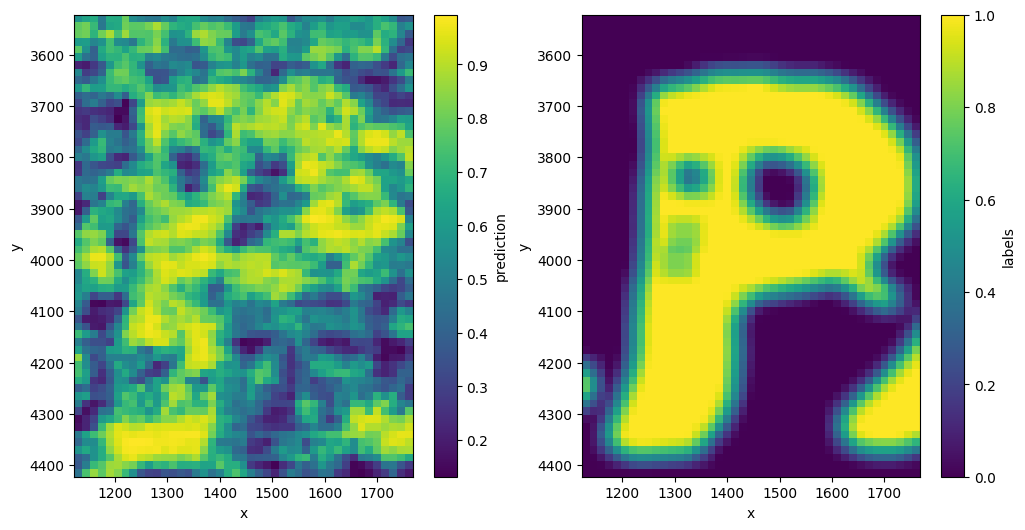

In [7]:
XL, YL = 1100, 3500  # lower left corner of the test box
WIDTH, HEIGHT = 1700, 1950
TEST_BOX = (XL, YL, XL + WIDTH, YL + HEIGHT)

time_start = time.time()
# force reload module

model.load_state_dict(torch.load("save_model/model_20230401_231930.pt"))
model.eval()

tvs = TestVolumeDataset(read_dataset_from_zarr(1, config.num_workers, config.prefix).isel(z=slice(*config.z_limit)),
                        config.box_width_xy,
                        transformer=None,
                        test_box=config.test_box,
                        z_limits=config.z_limit,
                        label_operation=label_operator)
test_loader = DataLoader(tvs, batch_size=config.batch_size, num_workers=0, shuffle=False)
time_end = time.time()
print(f"Loading test data took {time_end - time_start:.2f} seconds")

all_outputs = []
model.eval()
running_loss = 0
for i, (subvolumes, inklabels) in enumerate(test_loader):
    with torch.no_grad():
        outputs = model(subvolumes.to(DEVICE))
        all_outputs.append(outputs)
        loss = criterion(outputs, inklabels.to(DEVICE))
        running_loss += loss.item()

print(f"Loss: {running_loss / i} (step {i}) at {time.time() - time_start} seconds")
all_outputs = torch.cat(all_outputs, dim=0)
all_outputs = all_outputs.cpu().numpy().flatten()
tvs.ds_test_roll_sample['prediction'] = xr.DataArray(all_outputs.flatten(), dims=['sample'])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ds_pred = tvs.ds_test_roll_sample['prediction'].unstack('sample').transpose('y', 'x')
ds_pred.plot(ax=ax1)
ax1.invert_yaxis()
tvs.ds_test_roll_sample['labels'].mean(dim=['x_win', 'y_win']).unstack('sample').transpose('y', 'x').plot(ax=ax2)
ax2.invert_yaxis()

In [10]:
128 * 128 * 65 / 1000000

1.06496

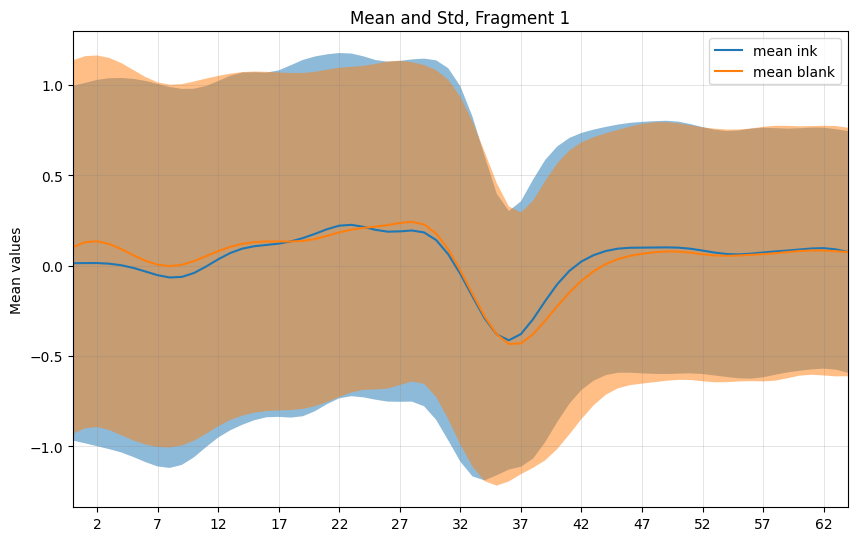

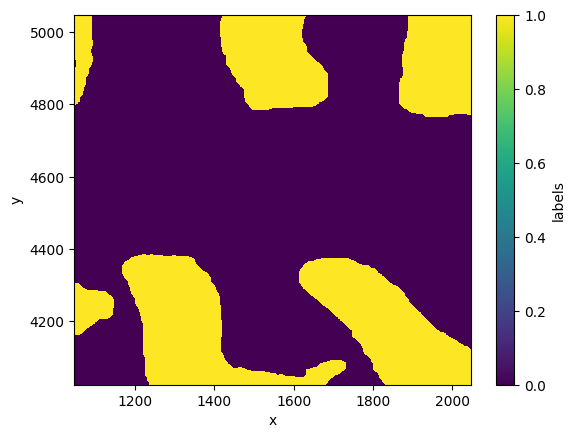

In [8]:
size = 2048
offy = 3000

for i in range(1, 2):
    # print(i)
    dsn = read_dataset_from_zarr(i, 5, config.prefix)
    dsn = dsn.isel(x=slice(1048, 2048), y=slice(1024 + offy, 2048 + offy)).load()
    dsn['images'] = dsn['images'].where(dsn.mask)

    fig, ax1 = plt.subplots(figsize=(10, 10 / 1.61803398875))

    with dask.config.set(scheduler='processes', num_workers=config.num_workers):
        # Mean plots with solid lines
        ds_ink = dsn.images.where(dsn.labels)
        ds_blank = dsn.images.where(~dsn.labels)
        mean_ink = ds_ink.mean(dim=['x', 'y'], skipna=True)
        mean_blank = ds_blank.mean(dim=['x', 'y'], skipna=True)
        std_ink = ds_ink.std(dim=['x', 'y'], skipna=True)
        std_blank = ds_blank.std(dim=['x', 'y'], skipna=True)

    x = np.arange(mean_ink.size)
    ax1.plot(x, mean_ink, label=f"mean ink")
    ax1.plot(x, mean_blank, label=f"mean blank")

    ax1.fill_between(x, mean_ink - std_ink, mean_ink + std_ink, alpha=0.5)
    ax1.fill_between(x, mean_blank - std_blank, mean_blank + std_blank, alpha=0.5)

    ax1.set_title(f"Mean and Std, Fragment {i}")
    ax1.set_ylabel("Mean values")
    ax1.grid(which='major', axis='both', linestyle='-', color='grey', linewidth=0.5, alpha=0.3)
    ax1.grid(which='minor', axis='both', linestyle='-', color='grey', linewidth=0.25, alpha=0.1)
    # Set vertical grid lines to be in increments of 1
    ax1.set_xticks(range(int(ax1.get_xlim()[0]), int(ax1.get_xlim()[1]) + 1, 5), minor=False)

    ax1.set_xlim(0, dsn.z.max().item())

    ax1.legend()

    plt.show()

    dsn.labels.plot.imshow()
    plt.show()

In [2]:

with dask.config.set(scheduler='processes', num_workers=config.num_workers):
    size = 64
    ll = 2048
    lr = 1024
    skip = 4
    mean_ink_stds = []
    mean_blank_stds = []
    for offsetx in range(0, 3000, skip * size):
        for offsety in range(0, 7168, skip * size):
            dsn = read_dataset_from_zarr(1, 5, config.prefix).isel(x=slice(ll, ll + size),
                                                                   y=slice(lr + offsety, lr + offsety + size))
            ink_cnt = (dsn.where(dsn.mask) == 1).labels.sum().item()
            blk_cnt = (dsn.where(dsn.mask) == 0).labels.sum().item()
            if (ink_cnt > 0 and blk_cnt > 0):
                dsn.load()
                # ax = plt.gca()
                # dsn.labels.plot.imshow(ax=ax)
                # ax.invert_yaxis()

                # fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20, 10))
                mean_dict = {}
                filters = [('blank', ax1, (dsn.labels == 0)),
                           ('ink', ax2, (dsn.labels == 1)),
                           ('both', ax3, (dsn.labels == 0) | (dsn.labels == 1))]
                for i, (title, ax, filt) in enumerate(filters):
                    mean_dict[i] = dsn['images'].where((dsn.mask > 0) & filt, drop=False).std(dim='x',
                                                                                              skipna=True).transpose(
                        'z', 'y')
                    # mean_dict[i].plot(vmin=0, vmax=2, ax=ax, label=f"Mean {title}")
                    ax.set_title(f"{title}")
                    ax.invert_yaxis()
                inkcount = (~np.isnan(dsn['images'].where((dsn.labels == 1), drop=False))).sum(dim='x',
                                                                                               skipna=True).transpose(
                    'z', 'y')
                # inkcount.plot(vmin=0, ax=ax4, label=f"{title}")
                # ax4.invert_yaxis()
                plt.show()

                ink_counts = inkcount.mean('z')
                mean_ink_std = mean_dict[1].mean('z')
                mean_blank_std = mean_dict[0].mean('z')
                mean_ink_stds.append(mean_ink_std)
                mean_blank_stds.append(mean_blank_std)
                # plt.scatter(*zip((ink_counts, mean_ink_std)), s=1)
                # plt.scatter(*zip((ink_counts, mean_blank_std)), s=1)
                # plt.xlabel("count")
                # plt.ylabel("mean")
                # plt.grid()
                # plt.show()

NameError: name 'ax1' is not defined

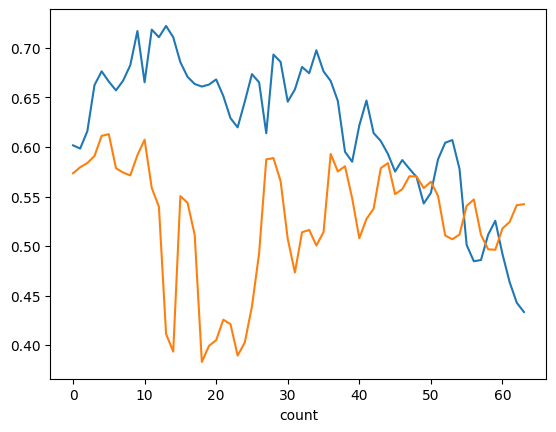

In [156]:
mean_ink_stds_da = xr.DataArray([v.values for v in mean_ink_stds], dims=['win', 'count'])
mean_blank_stds_ds = xr.DataArray([v.values for v in mean_blank_stds], dims=['win', 'count'])
mean_ink_stds_da.median(dim='win').plot()
mean_blank_stds_ds.median(dim='win').plot()

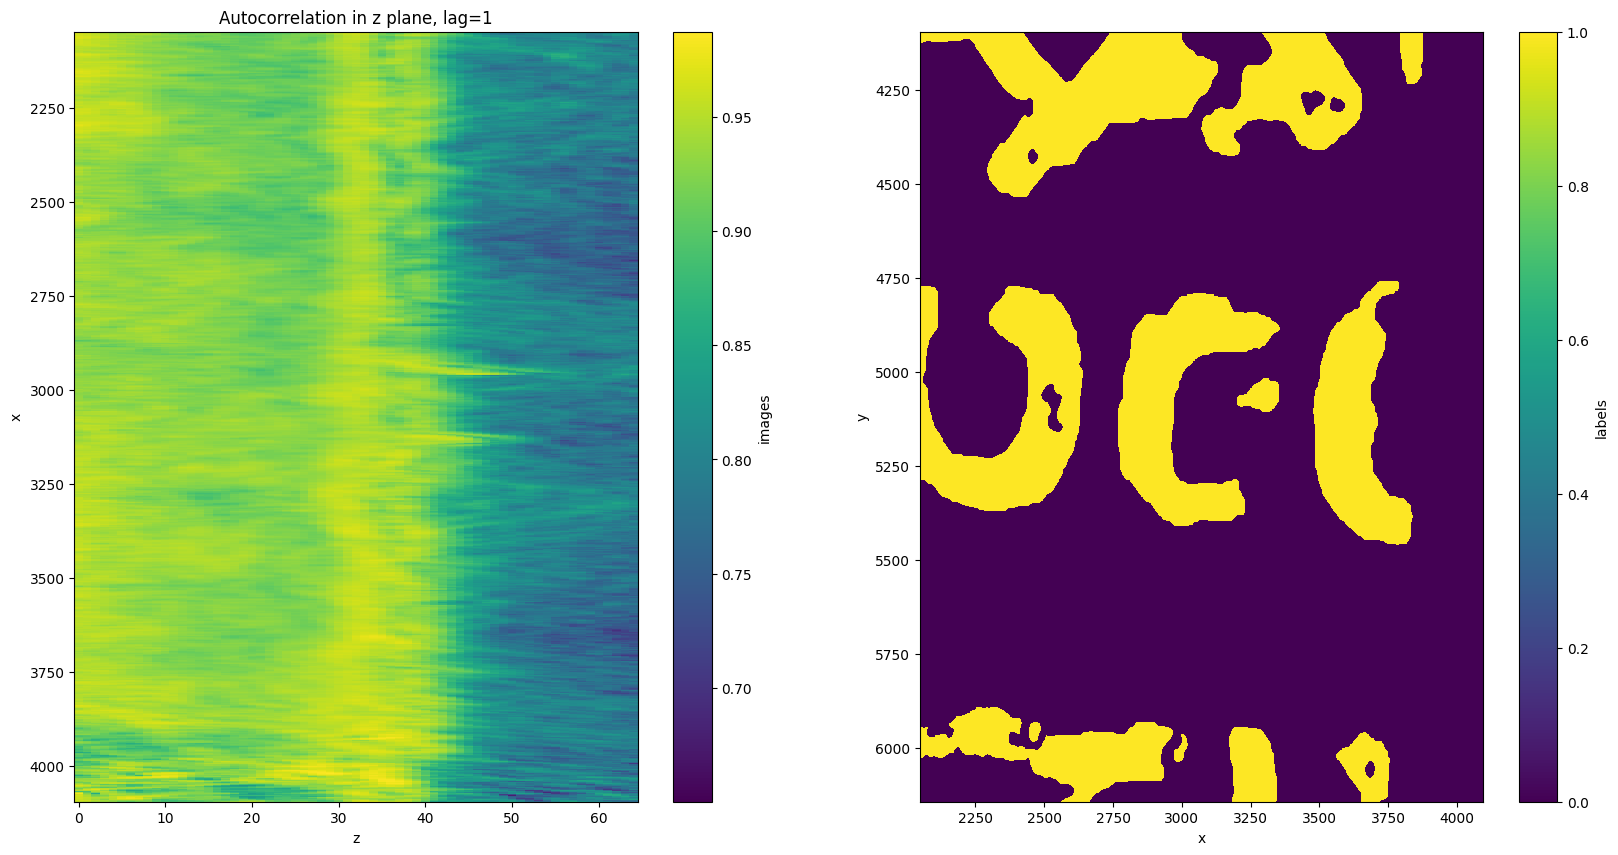

In [32]:
skipna = True


# Define a function to compute autocorrelation
def autocorrelation(arr, lag=2, dim='x'):
    original = arr
    shifted = arr.shift({dim: lag})
    numerator = (original - original.mean(dim, skipna=skipna)) * (shifted - shifted.mean(dim, skipna=skipna))
    denominator = (original - original.mean(dim)) ** 2
    return numerator.mean(dim, skipna=skipna) / denominator.mean(dim, skipna=skipna)


step = 1
size = 2 * 1024
xl = 1024 + 1 * 1024
yl = 4096 + 0 * 1024
dsn = read_dataset_from_zarr(1, 5, config.prefix).isel(x=slice(xl, xl + size, step), y=slice(yl, yl + size, step))
dsn.load()
dsn = normalise_images(dsn)

for i in range(1, 20):
    lag = i
    # Compute the autocorrelation in the z plane
    autocorrelation_z = autocorrelation(dsn.images, lag=lag, dim='y')

    # Print the result
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    autocorrelation_z.plot.imshow(ax=ax1)
    # title
    ax1.set_title(f"Autocorrelation in z plane, lag={lag // step}")
    ax1.invert_yaxis()
    dsn.labels.plot.imshow(ax=ax2)
    ax2.invert_yaxis()
    plt.show()
    break

In [ ]:
import pandas as pd

max_lag = 65
step = 1

dim = 'z'
lags = [(lag, autocorrelation(dsn.images, lag=lag, dim=dim).mean().item()) for lag in range(1, max_lag, step)]
df_both = pd.DataFrame(lags, columns=['lag', 'acorr_both'])
df_both.set_index('lag', inplace=True)

lags = [(lag, autocorrelation(dsn.images.where(dsn.labels), lag=lag, dim=dim).mean().item()) for lag in
        range(1, max_lag, step)]
df_ink = pd.DataFrame(lags, columns=['lag', 'acorr_ink'])
df_ink.set_index('lag', inplace=True)

lags = [(lag, autocorrelation(dsn.images.where(~dsn.labels), lag=lag, dim=dim).mean().item()) for lag in
        range(1, max_lag, step)]
df_blank = pd.DataFrame(lags, columns=['lag', 'acorr_blk'])
df_blank.set_index('lag', inplace=True)

acorrs = pd.concat([df_ink, df_blank, df_both], axis=1)

In [1]:
(acorrs['acorr_both'] - acorrs['acorr_blk']).plot()
plt.grid()
plt.show()

acorrs[['acorr_both', 'acorr_blk']].plot()
plt.grid()
plt.show()

NameError: name 'acorrs' is not defined

In [ ]:
(acorrs['acorr_ink'] - acorrs['acorr_blk']).plot()
plt.grid()

<AxesSubplot: xlabel='lag'>

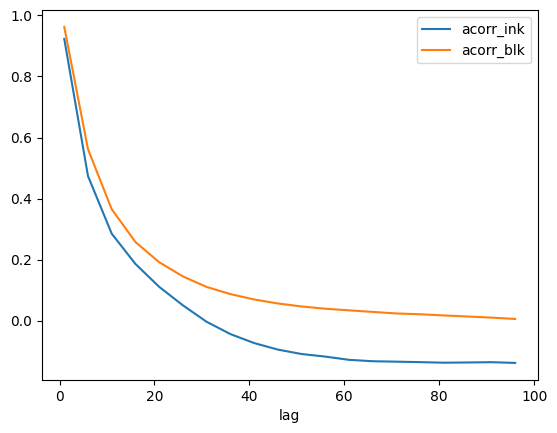

In [20]:
acorrs.plot()

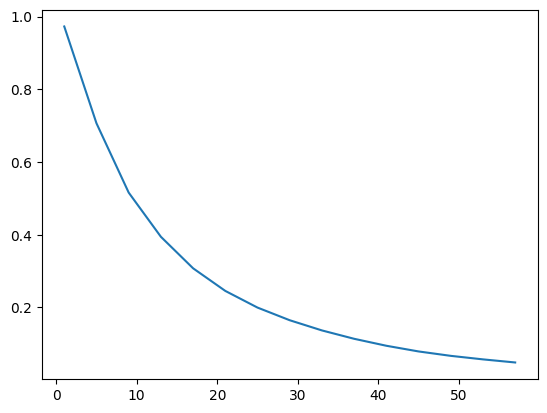

In [163]:
max_lag = 60
step = 4
lags = [(lag, autocorrelation(dsn.images, lag=lag, dim='x').mean().item()) for lag in range(1, max_lag, step)]
plt.plot(*zip(*lags))

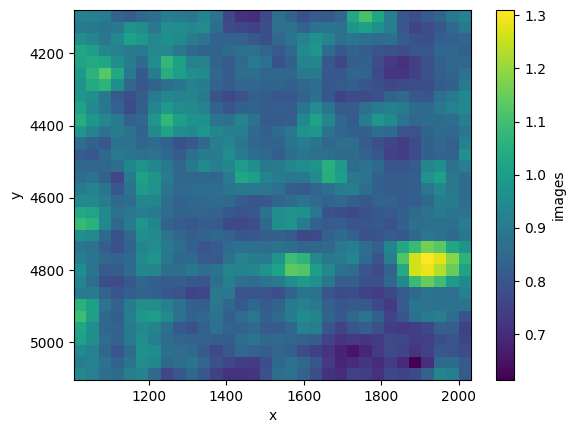

In [91]:
size = 1024
config.box_width_xy = 64
dsn = read_dataset_from_zarr(1, 5, config.prefix).isel(x=slice(1024, 1024 + size), y=slice(4096, 4096 + size))
dsn.load()


def get_rolling(ds):
    ds_roll = ds.rolling({'x': config.box_width_xy, 'y': config.box_width_xy}, center=True)
    ds_roll = ds_roll.construct(x='x_win', y='y_win', stride=config.box_width_xy // 2)
    return ds_roll


ax = plt.gca()
roll_images = get_rolling(dsn['images'])
roll_meam = roll_images.mean(dim=['x_win', 'y_win', 'z'])
roll_std = roll_images.std(dim=['x_win', 'y_win', 'z'])
(roll_std).plot.imshow(ax=ax)
ax.invert_yaxis()

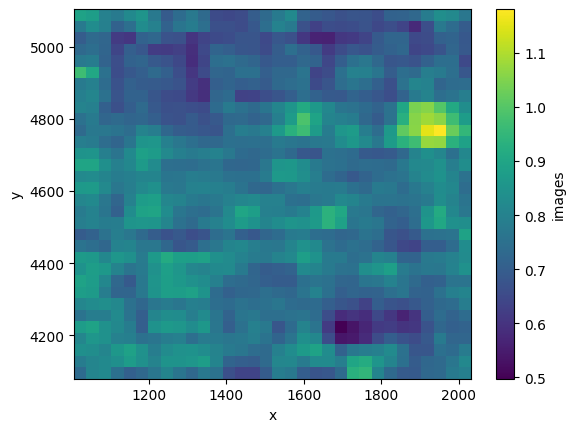

In [95]:
roll_images.std(dim=['x_win', 'y_win']).mean(dim="z").plot.imshow()

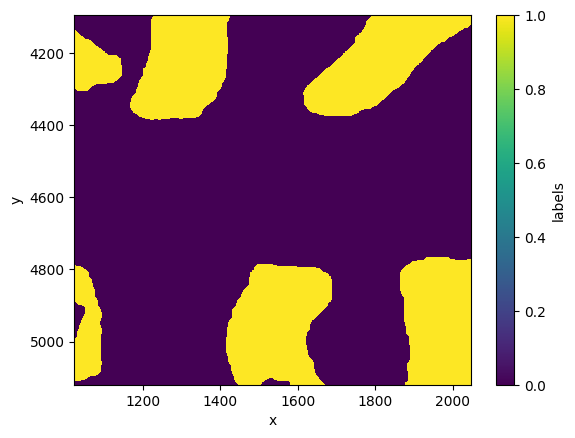

In [35]:
ax = plt.gca()
dsn.labels.plot.imshow(ax=ax)
ax.invert_yaxis()

In [4]:
config.box_width_xy = 32
config.box_width_xy

32

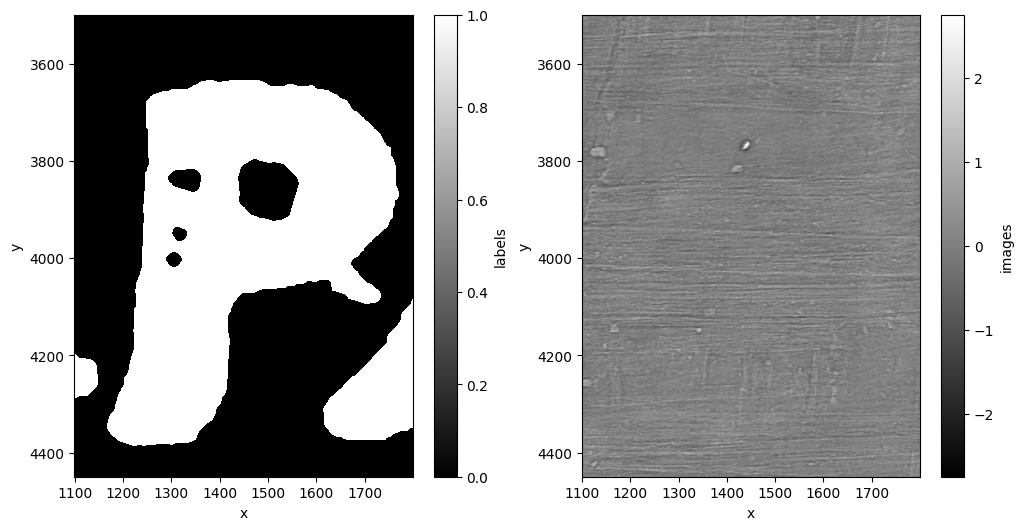

In [5]:
ds_test = read_dataset_from_zarr(1, 0, PREFIX).isel(x=slice(TEST_BOX[0], TEST_BOX[2]),
                                                    y=slice(TEST_BOX[1], TEST_BOX[3]))
ds_test.load()
ds_test['images'] = ds_test['images'].where(ds_test.mask)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ds_test.labels.astype(int).plot(ax=ax1, cmap='gray')
ax1.invert_yaxis()
ds_test.images.mean(dim='z').plot(ax=ax2, cmap='gray')
ax2.invert_yaxis()
plt.show()

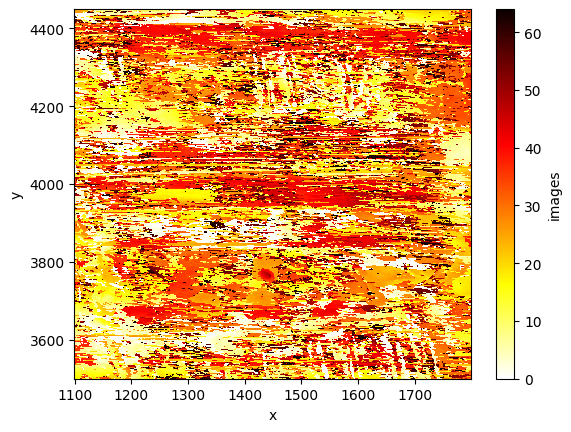

In [8]:
argmins = ds_test['images'].argmin(dim=['z'], skipna=True)
argmaxs = ds_test['images'].argmax(dim=['z'], skipna=True)
argmins['z'].plot.imshow(cmap='hot_r')
ax2.invert_yaxis()
plt.show()

In [ ]:
argmaxs

In [ ]:
ds_test['images'].where(ds_test.labels).mean(dim=['x', 'y'], skipna=True).plot()
ds_test['images'].where(~ds_test.labels).mean(dim=['x', 'y'], skipna=True).plot()
plt.show()

In [ ]:
`argmins['x']

In [ ]:
plt.scatter(argmins['x'], argmins['y'])
plt.show()

In [ ]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Assuming you already have the 'dsn' dataset and 'test_box' defined

fig, ax = plt.subplots()
num_frames = ds_test.z.max().item()


def update(frame):
    ax.clear()
    ds_test.images.isel(z=frame,
                        x=slice(TEST_BOX[0], TEST_BOX[2]),
                        y=slice(TEST_BOX[1], TEST_BOX[3])).plot(ax=ax, cmap='gray', add_colorbar=False)
    ax.invert_yaxis()
    return ax


ani = FuncAnimation(fig, update, frames=np.arange(0, num_frames), interval=100, blit=False)

# Save the animation
ani.save('animation.gif', writer='imagemagick', fps=5)

plt.show()

In [ ]:
ds_test = read_dataset_from_zarr(1)
ds_test.images

In [5]:
from dask.distributed import Client, LocalCluster

cluster = LocalCluster()
client = Client(cluster)

/home/john/.local/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39401 instead
  warnings.warn(


In [5]:
from core.data_io import read_dataset_from_zarr


def read_dataset_from_zarr(fragment: Union[int, str], workers: int, prefix: str, normalize: bool = True) -> xr.Dataset:
    zarr_path = join(prefix, str(fragment), 'surface_volume.zarr')
    if not os.path.exists(zarr_path):
        with dask.config.set(sscheduler='synchronous', num_workers=workers):
            save_zarr(fragment, prefix, normalize)
    sync = ProcessSynchronizer('/tmp/tmpz7x9z5xh')
    # sync = ThreadSynchronizer()
    with dask.config.set(sscheduler='synchronous'):
        dataset = xr.open_zarr(zarr_path,
                               consolidated=True,
                               synchronizer=sync,
                               zarr_version=2,
                               chunks={'z': 65})
    dataset.mask.load()
    dataset.labels.load()
    return dataset


ds_test = read_dataset_from_zarr(DEMO_FRAGMENT, NUM_WORKERS, PREFIX).isel(z=slice(27, 36))
# # ds_test.load()
# ds_test['full_mask'] = ds_test['mask']
# test_dataset = VolumeDataset(ds_test,
#                              BOX_WIDTH_SAMPLE,
#                              10000000,
#                              transformer=None,
#                              crop_box_cls=CropBoxSobol,
#                              label_operation=label_operator,
#                              balance_ink=False)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=1, prefetch_factor=20)
# tli = iter(test_loader)
#
# for i in range(100):
#     dd = next(tli)[0]
#     print(i, dd.mean(), dd.shape)

In [7]:
import zarr
import numpy as np
import time

# Define array dimensions and chunk size
array_shape = (640, 640, 100)
chunk_size = (64, 64, 10)
dtype = 'float32'

# Create the Zarr array with the specified dimensions and chunk size
zarr_array = zarr.zeros(array_shape, chunks=chunk_size, dtype=dtype, store='large_array.zarr')

# Populate the array with random data
zarr_array[:] = np.random.rand(*array_shape)

# Load the Zarr array from disk
zarr_array_from_disk = zarr.open('large_array.zarr', mode='r')


# Define a function to read a random chunk from the Zarr array
def read_random_chunk(array, chunk_size):
    x, y, z = array.shape
    cx, cy, cz = chunk_size
    x_idx = np.random.randint(0, x - cx + 1)
    y_idx = np.random.randint(0, y - cy + 1)
    z_idx = np.random.randint(0, z - cz + 1)
    return array[x_idx:x_idx + cx, y_idx:y_idx + cy, z_idx:z_idx + cz]


# Test different chunk sizes
chunk_sizes_to_test = [
    (64, 64, 10),
    (128, 128, 10),
    (256, 256, 10),
    (64, 64, 20),
    (128, 128, 20),
]

# Number of times to repeat the read operation for each chunk size
num_repeats = 100

for test_chunk_size in chunk_sizes_to_test:
    time_taken_list = []
    running_avg_time_taken = 0
    for _ in range(num_repeats):
        start_time = time.time()
        chunk_data = read_random_chunk(zarr_array_from_disk, test_chunk_size)
        end_time = time.time()

        time_taken = end_time - start_time
        time_taken_list.append(time_taken)

    avg_time_taken = np.mean(time_taken_list)
    running_avg_time_taken += avg_time_taken
    print(
        f"Average time taken to read chunk of size {test_chunk_size}: {1_000_000 * running_avg_time_taken / num_repeats:.6f} us")

Average time taken to read chunk of size (64, 64, 10): 18.934393 us
Average time taken to read chunk of size (128, 128, 10): 44.455004 us
Average time taken to read chunk of size (256, 256, 10): 136.426878 us
Average time taken to read chunk of size (64, 64, 20): 29.334760 us
Average time taken to read chunk of size (128, 128, 20): 72.828388 us


In [17]:
import numpy as np


# Define your function here
def my_function(x):
    return x ** 2  # Example: quadratic function


# Sequence from 0 to 64
sequence = np.arange(65)

# Compute the function values for the sequence
function_values = np.array([my_function(x) for x in sequence])

# Normalize the function values to create a probability distribution
prob_distribution = function_values / np.sum(function_values)

# Compute the cumulative sum of the probability distribution
cumulative_sum = np.cumsum(prob_distribution)

# Create an array of equally spaced values between 0 and 1, excluding the endpoint
sampling_points = np.linspace(0, 1, 10, endpoint=False)

# Find the indices for the sampling points in the cumulative sum
sample_indices = np.searchsorted(cumulative_sum, sampling_points)

# Get the sampled values from the sequence
sampled_values = sequence[sample_indices]

print("Sampled Values:", sampled_values)


Sampled Values: [ 0 30 38 43 48 51 54 57 60 62]


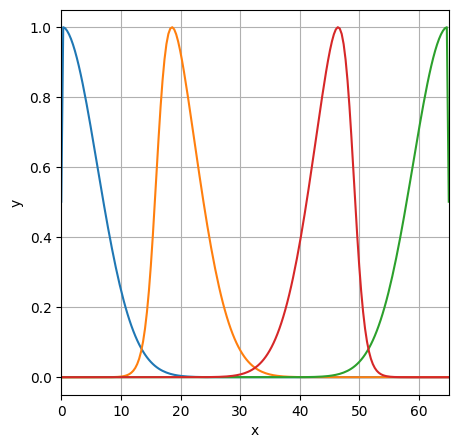

In [170]:
import numpy as np
import matplotlib.pyplot as plt


def gsg(x, A, k, x0, b, c):
    return A / (1 + np.exp(-k * (x - x0))) ** (1 / b) * np.exp(-(x - x0) ** 2 / (2 * c ** 2))


fig = plt.figure(figsize=(5, 5))

width = 6
for reverse in (1, -1):
    for args in [
        (1, 20, 0, 1, width),
        (1, 1, 65 // 4, 1, width),
    ]:
        x = np.linspace(0, 65, 200)
        y = gsg(x, *args)[::reverse]
        y /= y.max()
        plt.plot(x, y)
plt.xlabel('x')
plt.ylabel('y')
plt.xlim((0, 65))
# plt.title('Generalized Sigmoid Gaussian function')
plt.grid()
plt.show()

In [15]:
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

dataset = MNIST(root='data/', download=True, transform=ToTensor())
dataloader = DataLoader(dataset, batch_size=32)

# Use the DataLoader in a with statement to ensure it is properly closed
with dataloader:
    for batch in dataloader:
        print(batch)

100%|██████████| 9912422/9912422 [00:02<00:00, 3681605.44it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 100194949.40it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 4047242.41it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 20074319.04it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



AttributeError: __enter__